In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import datetime
import os
import os.path
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
#Setting device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


batch_size = 4

# Number of training epochs
num_epochs = 200

#Flag to load pretrained model
LOAD_MODEL = True

#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/p_virus_200_2020-08-22_15:49:13.dat' #P_vir_200_opt
#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/p_bacteria_200_2020-08-22_16:21:47.dat' #P_bac_200_opt
#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/normal_200_2020-08-22_16:38:52.dat' #Normal_200_opt
#PATH='/AUGMENTATION_GAN/gan_models/epoch_200/covid_200_2020-08-22_16:58:21.dat' #Covid_200_opt

TRAIN_ALL = False
#All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.002
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
criterion = nn.BCELoss()

In [4]:
import torch.nn as nn

def weights_init(m):
    """
    Custom weight initialization for neural network layers.

    This function is typically passed to `model.apply()` to initialize all layers
    of a PyTorch model according to the type of layer.

    - Convolutional layers (`Conv*`) are initialized with a normal distribution
      (mean=0.0, std=0.02).
    - Batch normalization layers (`BatchNorm*`) are initialized with:
        - weights from a normal distribution (mean=1.0, std=0.02)
        - biases set to zero.

    Args:
        m (nn.Module): A module (layer) of the neural network.
    """
    classname = m.__class__.__name__

    # Check if the layer is a convolutional layer
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    # Check if the layer is a batch normalization layer
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [1]:
# class Generator(nn.Module):

#     def __init__(self):
#         super(Generator, self).__init__()
#         self._model = nn.Sequential(
#             # input is Z, going into a convolution
#             #i/p,o/p,kernel size,stride,padding
#             nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 16),
#             nn.ReLU(True),
#             # state size. (ngf*16) x 4 x 4
#             nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 8 x 8
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 16 x 16
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 32 x 32
#             nn.ConvTranspose2d( ngf*2, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self._model(input)

# Generator function for GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    # Forward Propogation
    def forward(self, input):
        return self.main(input)

NameError: name 'nn' is not defined

In [ ]:
# class Discriminator(nn.Module):

#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self._model = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 32 x 32
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 16 x 16
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 8 x 8
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*16) x 4 x 4
#             nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self._model(input)

# Discriminator function for GAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    # Forward Propogation
    def forward(self, input):
        return self.main(input)

In [2]:
def plot(name, train_epoch, values, path, save):
    """
    Plots training metrics over epochs and optionally saves the figure.

    Parameters:
    - name (str): Metric name (e.g., 'loss').
    - train_epoch (int): Current epoch number.
    - values (list): List of metric values.
    - path (str): Directory to save the plot.
    - save (bool): If True, saves the plot as a PNG file.
    """
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [5]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):

    """
    Saves model and optimizer states along with training metrics and plots.

    Parameters:
    - generator (nn.Module): Trained generator model.
    - discriminator (nn.Module): Trained discriminator model.
    - gen_optimizer (Optimizer): Optimizer for the generator.
    - dis_optimizer (Optimizer): Optimizer for the discriminator.
    - metrics (dict): Dictionary of training metrics.
    - num_epochs (int): Current epoch number.
    """
    # Get current timestamp
    now = datetime.datetime.now()

    # Get latest generator and discriminator losses for naming
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]

    # Format filename using losses, epoch, and timestamp
    name = "%+.3f_%+.3f_%d_%s.dat" % (g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'augGAN/model', name)

    # Prepare the model state dictionary for saving
    states = {
            'state_dict_generator': generator.state_dict(),
            'state_dict_discriminator': discriminator.state_dict(),
            'gen_optimizer': gen_optimizer.state_dict(),
            'dis_optimizer': dis_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': num_epochs,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    # Save model checkpoint
    torch.save(states, fname)

    # Create a new directory for saving plots
    path='augGAN/plots/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    # Generate and Save plots for training metrics
    plot('G_losses', num_epochs, metrics['train.G_losses'], path, True)
    plot('D_losses', num_epochs, metrics['train.D_losses'], path, True)
    plot('D_x', num_epochs, metrics['train.D_x'], path, True)
    plot('D_G_z1', num_epochs, metrics['train.D_G_z1'], path, True)
    plot('D_G_z2', num_epochs, metrics['train.D_G_z2'], path, True)

In [6]:
img_list = []
G_losses = []
D_losses = []

def train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader, num_epochs, metrics):


        """
    Trains a GAN using the given generator and discriminator models, optimizers, and dataloader.
    Logs performance metrics and saves model checkpoints and sample outputs.
    """
        iters = 0
        print("GAN training started :D...")

        for epoch in range(num_epochs):
            print("Epoch %d" %(epoch+1))
            # For each batch in the dataloader
            for i, data in enumerate(tqdm(train_loader, 0)):
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ## Train with all-real batch
                discriminator.zero_grad()
                # Format batch
                b_real = data[0].to(device)
                b_size = b_real.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = discriminator(b_real).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()
                metrics['train.D_x'].append(D_x)

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = generator(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = discriminator(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                metrics['train.D_G_z1'].append(D_G_z1)
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                dis_optimizer.step()
                # if i>0:
                #     if errD.item()>G_losses[i-1]:
                #         dis_optimizer.step()
                # else:
                #     dis_optimizer.step()

                # (2) Update G network: maximize log(D(G(z)))
                generator.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = discriminator(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                metrics['train.D_G_z2'].append(D_G_z2)
                # Update G
                gen_optimizer.step()

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())
                metrics['train.G_losses'].append(errG.item())
                metrics['train.D_losses'].append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake = generator(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs)

In [7]:
def get_indices(dataset, class_name, indices):
    """
    Appends indices of samples with the given class label to the provided list.

    Args:
        dataset: Dataset object with a 'targets' attribute.
        class_name: Target class label to match.
        indices: List to append matching indices to.

    Returns:
        List of indices corresponding to the specified class.
    """
    j = 0
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
            j += 1
    print("Total Samples of class", class_name,"found are",j)
    return indices

In [9]:
def test1(generator, discriminator, num_epochs, metrics):
    """
    Generates and saves a batch of fake images using the trained generator.

    Args:
        generator: Trained generator model.
        discriminator: Trained discriminator model (unused here).
        num_epochs: Number of epochs the model was trained for.
        metrics: Dictionary containing training metrics (used for loss values).
    """
    print('Testing Block.........')
    # Get current Datetime
    now = datetime.datetime.now()
    # Extract latest Generator and discriminator losses
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]


    path='augGAN/output_images'
    # Create Directory for saving output images if already doesn't exist
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    test_img_list = []
    # Generate random noise input for the generator
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    # Generate fake images from the noise
    test_fake = generator(test_noise).detach().cpu()
    # Create grid of fake images for visualisaton
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    # Plotting the images
    fig = plt.figure(figsize=(15,15))
    fig = plt.axis("off")
    fig = plt.title("Fake Images")
    fig = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    get_fig = plt.gcf()
    fig = plt.show()
    # Save the generated image with losses, epoch, and timestamp in filename
    get_fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                    (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [10]:
def test2(generator, discriminator, num_epochs, metrics, loader):
    """
    Generate and display real and fake images side by side, then save the figure.

    Args:
        generator: Trained generator model.
        discriminator: Trained discriminator model (not used here).
        num_epochs: Number of epochs the model was trained for.
        metrics: Dictionary containing training metrics (used for loss values).
        loader: DataLoader for real images.
    """
    print('Testing Block.........')
    now = datetime.datetime.now()

    # Get the latest generator and Discriminator losses
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]

    # Create directory for saving output images if it already doesn't exist
    path='augGAN/output_images'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    # Get a batch of real images from the dataloader
    real_batch = next(iter(loader))

    test_img_list = []
    # Generate random noise to feed the generator
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    # Generate fake images from the noise
    test_fake = generator(test_noise).detach().cpu()
    # Create a grid of fake images for display
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(15,15))

    # Plot Real images
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot fake images
    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    #ax2 = plt.show()

    # Save the figure with losses and epoch info in the filename
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                    (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [11]:
def test_fake(generator, discriminator, metrics, n_images, folname):
    """
    Generates fake images using the generator, saves them in batches, and prints discriminator output stats.

    Args:
        generator: Trained generator model.
        discriminator: Trained discriminator model.
        metrics: Dictionary containing training metrics.
        n_images: Total number of fake images to generate.
        folname: Folder name for saving images.
    """

    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]

    # Define directory path for saving generated images
    #path='augGAN/output_images/%+.3f_%+.3f_%d_%s'% (g_losses, d_losses, n_images, now.strftime("%Y-%m-%d_%H:%M:%S"))
    path='main_folder/'+str(n_images)+'/'+folname
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    im_batch_size = 50    # Number of images to generate per batch
    #n_images=100

    # Generate images in batches to avoid memory overload
    for i_batch in range(0, n_images, im_batch_size):
        gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
        gen_images = generator(gen_z)

        # Get discriminator's output on generated images
        dis_result = discriminator(gen_images).view(-1)

        # Prepare images for saving: move to CPU, detach from graph, convert to numpy, and transpose for saving
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        # Save each generated image individually
        for i_image in range(gen_images.size(0)):
            save_image(gen_images[i_image, :, :, :], os.path.join(path,
                        f'image_{i_batch+i_image:04d}.png'), normalize= True)

    print('Testing Block.........')
    # Print mean discriminator score for generated images
    print('Discriminator_mean: ', dis_result.mean().item())

    # Optional: archive saved images (commented out)
    #import shutil
    #shutil.make_archive('images', 'zip', './augGAN/output_images')

In [12]:
# Create required directories if they don't already exist
for func in [
    lambda: os.mkdir(os.path.join('.', 'augGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/model')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/plots')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/output_images'))]:  # create directories
  try:
    func()
  except Exception as error:
    print(error)  # Print error if directory already exists or other issues
    continue

# Define metric fields to keep track of during training
METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
]

# Initialize metrics dictionary with empty lists for each metric
metrics = {field: list() for field in METRIC_FIELDS}

# Define normalization parameters and transforms depending on number of channels (nc)
if nc==1:
    mu = (0.5)
    sigma = (0.5)
    transform = transforms.Compose([
        # Convert image to grayscale with 1 output channel
        transforms.Grayscale(num_output_channels=1),
        # Resize images to 64x64 pixels
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # Normalize pixel values to mean=0.5, std=0.5
        transforms.Normalize(mu, sigma)])
elif nc==3:
    mu = (0.5,0.5,0.5)
    sigma = (0.5,0.5,0.5)
    # For RGB images: resize, convert to tensor, and normalize
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mu, sigma)])
else:
    print("Tranformation not defined for this option")

# Define the base data directory path
data_dir = '/Thyroid Data DCGAN/DU'

# Load different training datasets with the defined transform
trainset0 = datasets.ImageFolder(os.path.join(data_dir, "Train/"), transform=transform)
trainset500 = datasets.ImageFolder(os.path.join(data_dir, "Train_classic/500/"), transform=transform)
trainset1000 = datasets.ImageFolder(os.path.join(data_dir, "train_classic/1000/"), transform=transform)
trainset2000 = datasets.ImageFolder(os.path.join(data_dir, "train_classic/2000/"), transform=transform)

# Combine datasets into lists for easier concatenation
listtrainset_no_aug = [trainset0]
listtrainset_classic = [trainset500, trainset1000]  # trainset2000 is commented out
listtrainset = listtrainset_no_aug + listtrainset_classic

# Concatenate all training datasets into a single dataset
train_set = torch.utils.data.ConcatDataset(listtrainset)

# Instantiate Generator and Discriminator models, move to device (CPU/GPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize model weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Setup Adam optimizers with learning rates and beta parameters
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

# Load pretrained models if flag is set
if LOAD_MODEL:
    if torch.cuda.is_available():
        checkpoint = torch.load(PATH)
    else:
        # Load on CPU if CUDA not available
        checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)

    # Load saved state dicts for generator, discriminator, and optimizers
    generator.load_state_dict(checkpoint['state_dict_generator'])
    discriminator.load_state_dict(checkpoint['state_dict_discriminator'])
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer'])
    dis_optimizer.load_state_dict(checkpoint['dis_optimizer'])
    metrics = checkpoint['metrics']
    num_epochs = checkpoint['train_epoch']
    date = checkpoint['date']

    # Set models to evaluation mode (disable dropout, batchnorm updates)
    generator.train(mode=False)
    discriminator.train(mode=False)

    print('GAN loaded for epochs: ', num_epochs)
    print(generator)
    print(discriminator)
    print(gen_optimizer)
    print(dis_optimizer)
    print(date)
    # Optionally run a test function here
    # test1(generator, discriminator, num_epochs, metrics)

else:
    if TRAIN_ALL:
        # Prepare dataloader for entire training set, shuffling enabled
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

        # Train GAN on full dataset
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader,
                  num_epochs, metrics)
        # Run test function with trained models
        test2(generator, discriminator, num_epochs, metrics, train_loader)
    else:
        # Optionally filter dataset by class index (commented example for x-ray dataset)
        # idx = []
        # idx = get_indices(train_set, 4, idx) # e.g., 0 for covid, etc.

        # Create dataloader and mask to filter only samples with label 0 (e.g., covid)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        mask = [x[1] == 0 for x in train_loader.dataset]  # select samples of class 0
        idx = np.arange(len(train_loader.dataset))[mask]

        print("Total samples now are ", len(idx))

        # Create dataloader with subset sampler to load only filtered samples
        selected_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      sampler=SubsetRandomSampler(idx))

        # Train GAN on filtered subset
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, selected_loader,
                  num_epochs, metrics)
        # Test on filtered subset
        test2(generator, discriminator, num_epochs, metrics, selected_loader)
        # Test on full set (or default)
        test1(generator, discriminator, num_epochs, metrics)


name 'os' is not defined
name 'os' is not defined
name 'os' is not defined
name 'os' is not defined


NameError: name 'nc' is not defined

Total Samples of class 0 found are 60
class label for real tensor([0])
Discriminator s o/p tensor([[[[0.4945]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


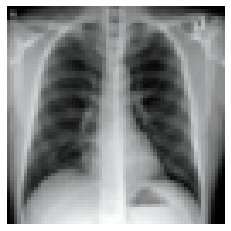

In [ ]:
#Testing cell....to visualize
test_batch = 1 #No of images to be genertaed in stack
test_fake_id = 1 #To generate fake images or just view real images
LOAD_ID = 0 #Class of images in case test_fake_id is 0

if test_fake_id:
  #check for fake image
  test_img_list = []
  test_noise = torch.randn(test_batch, nz, 1, 1, device=device)
  test_img = generator(test_noise)#.detach().cpu()

else:
  #check for real image
  idx = []
  #train_set = datasets.ImageFolder("main_folder/100/", transform=transform)
  idx = get_indices(train_set, LOAD_ID, idx)
  test_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch,
                                                sampler = SubsetRandomSampler(idx))
  data = next(iter(test_loader))
  test_noise, test_class_lable = data
  test_img.data.resize_(test_noise.size()).copy_(test_noise)
  #print(data[0].size())
  print('class label for real', test_class_lable)

s_output = discriminator(test_img.detach().to(device))
print('Discriminator s o/p', s_output)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.axis('off')
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

In [ ]:
test_fake(generator, discriminator, metrics, 500, "normal")

Testing Block.........
Discriminator_mean:  0.5166683793067932


In [ ]:
#To confimr no of images in a specified class
path, dirs, files = next(os.walk(os.path.join(data_dir, "train/pneumonia_vir")))
print(len(files))

71


In [ ]:
from torchsummary import summary
# Generate architecture summary for generator and discriminator network

summary(generator, (100, 1, 1))
summary(discriminator, (1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,024
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Dropout: 2-3                      [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-5                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-7                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-8                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-9                    [-1, 256, 8, 8]           --
|    └─Dropout: 2-10                     [-1, 256, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-12                 [-1, 512, 4, 4]       

In [ ]:
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
